In [1]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.facecolor'] = "w"

from sklearn.cluster import KMeans


import random
random.seed(30)


# Read data

In [3]:
hh0 = pd.read_csv('rt_hrl_lmps.csv', 
                 parse_dates=True)
hh0.head()

,datetime_beginning_utc,datetime_beginning_ept,pnode_id,pnode_name,voltage,equipment,type,zone,system_energy_price_rt,total_lmp_rt,congestion_price_rt,marginal_loss_price_rt,row_is_current,version_nbr
0,5/1/2021 4:00:00 AM,5/1/2021 12:00:00 AM,34885183,ACCA,13 KV,TX1,LOAD,DOM,18.29,9.29,-9.40,0.40,True,1
1,5/1/2021 4:00:00 AM,5/1/2021 12:00:00 AM,34885185,ACCA,13 KV,TX2,LOAD,DOM,18.29,9.30,-9.40,0.41,True,1
2,5/1/2021 4:00:00 AM,5/1/2021 12:00:00 AM,34885193,ALLIED,13 KV,TX1,LOAD,DOM,18.29,9.43,-9.19,0.33,True,1
3,5/1/2021 4:00:00 AM,5/1/2021 12:00:00 AM,34885195,ALLIED,13 KV,TX2,LOAD,DOM,18.29,9.43,-9.19,0.33,True,1
4,5/1/2021 4:00:00 AM,5/1/2021 12:00:00 AM,34885197,ALLIED,13 KV,TX3,LOAD,DOM,18.29,9.43,-9.19,0.33,True,1


In [4]:
hh0.columns

Index(['datetime_beginning_utc', 'datetime_beginning_ept', 'pnode_id',
       'pnode_name', 'voltage', 'equipment', 'type', 'zone',
       'system_energy_price_rt', 'total_lmp_rt', 'congestion_price_rt',
       'marginal_loss_price_rt', 'row_is_current', 'version_nbr'],
      dtype='object')

In [6]:
hh0.type.unique()

array(['LOAD'], dtype=object)

In [7]:
len(hh0['pnode_id'].unique())

167

In [9]:
hh0 = hh0[['datetime_beginning_utc','pnode_id','total_lmp_rt']]

In [10]:
hh0.columns =['timestamp','pnode_id','total_lmp_rt']
hh0.head()

,timestamp,pnode_id,total_lmp_rt
0,5/1/2021 4:00:00 AM,34885183,9.29
1,5/1/2021 4:00:00 AM,34885185,9.30
2,5/1/2021 4:00:00 AM,34885193,9.43
3,5/1/2021 4:00:00 AM,34885195,9.43
4,5/1/2021 4:00:00 AM,34885197,9.43


In [11]:
## parse timestamp
hh0['timestamp'] = pd.to_datetime(hh0['timestamp'])

C:\Users\54651\Anaconda3\envs\random_env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Define functions

In [12]:
## Helper Functions

def reshape2daily(df_in):
    """
    DESCRIPTION: Reshapes input dataframe with hourly resolution to a dataframe with daily resolution, 
                 where every column contains data for a particular hour & different consumers are stacked verticaly.
    
    Input:
    df_in (pd.DataFrame): Dataframe holding time series data with hourly resolution in every column. Indices are timestamps.
    
    Output:
    df (pd.DataFrame): Dataframe holding time series data with daily resolution and hours in every columns.
    
    """
    df = (pd.pivot_table(df_in, 
                         values="kwh", 
                         index=[df_in.timestamp.dt.to_period("D"), df_in.cons_id],   
                         columns=df_in.timestamp.dt.strftime("%H:%M")
                         )
            .reset_index()
            .sort_values(["cons_id", "timestamp"])
            .set_index("timestamp")
         )
    return df


def reshape2weekly(df_in):
    """
    DESCRIPTION: Reshapes input dataframe with hourly resolution to a dataframe, 
                 where every consumer has a weekly mean profile in each row. 
    
    Input:
    df_in (pd.DataFrame): Dataframe holding time series data with hourly resolution in every column. Indices are timestamps.
    
    Output:
    df (pd.DataFrame): Dataframe holding time series data with daily resolution and hours in every columns.
    
    """
    df = (pd.pivot_table(df_in, 
                         values="kwh", 
                         index=df_in.cons_id,
                         columns=[df_in.timestamp.rename("dayofweek").dt.dayofweek, 
                                  df_in.timestamp.rename("hour").dt.hour],
                         aggfunc='mean'
                         )
            .round(3)
         )
    return df

## 12 months x weekday only x 24 hours  (288 columns)
def reshape2monthly(df_in):

    df = (pd.pivot_table(df_in, 
                         values="kwh", 
                         index=[df_in.cons_id,df_in.timestamp.dt.dayofweek],   
                         columns=[df_in.timestamp.rename("month").dt.month, 
                                  df_in.timestamp.rename("hour").dt.hour],
                         aggfunc='mean')
            .reset_index()
            .sort_values(["cons_id", "timestamp"])
            .set_index("timestamp")
         )
    df = df.loc[df.index < 5].groupby("cons_id").mean()
    return df

## 4 quarters x weekday/weekend x 24hrs (96 columns)
def reshape2quarterly(df_in):

    df = (pd.pivot_table(df_in, 
                         values="kwh", 
                         index=[df_in.cons_id,df_in.timestamp.dt.dayofweek],   
                         columns=[df_in.timestamp.rename("quarter").dt.quarter, 
                                  df_in.timestamp.rename("hour").dt.hour],
                         aggfunc='mean')
            .reset_index()
            .sort_values(["cons_id", "timestamp"])
            .set_index("timestamp")
         )
    df_workingdays = df.loc[df.index < 5].groupby("cons_id").mean()
    df_weekends = df.loc[df.index > 5].groupby("cons_id").mean()
    df_all = df_workingdays.join(df_weekends,lsuffix = "workday",rsuffix="weekend")
    return df_all

def normalize_df(df):
    """
    DESCRIPTION: Normalizes input dataframe according to daily maximum.
    """
    # fillna is for profiles with only zeros per day
    return df.apply(lambda s: s / df.max(axis=1)).fillna(0)



## for plotting
x_axis = pd.date_range("2019-1-1", periods=24, freq="1h").strftime("%H:%M")

weekday_names = ["Mon", "Tue", "Wen", "Thu", "Fri", "Sat", "Sun"]
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul","Aug","Sep","Oct","Nov","Dec"]
quarter_names = ["Q1-weekday","Q2-weekday",  "Q3-weekday", "Q4-weekday","Q1-weekend", "Q2-weekend","Q3-weekend",  "Q4-weekend"]   

def plot_cluster_centroids(df, clust, lw=4, alpha=0.6):
    """
    DESCRIPTION: Plots cluster centroids.
    """
    
    weekly = True if df.shape[1] == 168 else False
    monthly = True if df.shape[1] == 288 else False 
    quarterly = True if df.shape[1] == 192 else False
    if weekly:
        figsize = [15, 4] 
    elif monthly:
        figsize = [25, 4] 
    elif quarterly:
        figsize = [20, 4]
    else:
        figsize = [8, 6]
    
    fontsize = 15
    fig = plt.figure(figsize=figsize)
    
    df.assign(clust=clust).groupby("clust").mean().T.plot(ax=plt.gca(), lw=lw, alpha=alpha);

    plt.title("Cluster Centroids", fontsize=fontsize+5);
    plt.xticks(np.arange(0, len(x_axis), 4), x_axis[::4], fontsize=fontsize);
    
    if weekly:
        plt.xticks(np.arange(0, df.shape[1], 24), 
                   weekday_names, 
                   fontsize=fontsize);
        xposition = np.arange(0, df.shape[1], 24)
        for xc in xposition:
            plt.axvline(x=xc, color='tab:gray', linestyle='--')
    if monthly:
        plt.xticks(np.arange(0, df.shape[1], 24), 
                   month_names, 
                   fontsize=fontsize);
        xposition = np.arange(0, df.shape[1], 24)
        for xc in xposition:
            plt.axvline(x=xc, color='tab:gray', linestyle='--')
    if quarterly:
        plt.xticks(np.arange(0, df.shape[1], 24), 
                   quarter_names, 
                   fontsize=fontsize);
        xposition = np.arange(0, df.shape[1], 24)
        for xc in xposition:
            plt.axvline(x=xc, color='tab:gray', linestyle='--')
    
    plt.yticks(fontsize=fontsize);
    plt.xlabel("")
    plt.ylabel("$P/P_{max}$", fontsize=fontsize)
    plt.legend(title="Cluster centroids:", loc="upper left")
    plt.grid()


def plot_clustered_profiles(df, clust, n_cols=3, alpha=0.2):
    """
    DESCRIPTION: Plots one subplot per cluster, where each subplot contains
                    all profiles in a particular cluster together with a cluster centroid.
    """
    
    weekly = True if df.shape[1] == 168 else False
    monthly = True if df.shape[1] == 288 else False 
    quarterly = True if df.shape[1] == 192 else False

    clust_perc = 100 * clust.value_counts(normalize=True)

    n_rows = np.ceil(clust.nunique() / n_cols)
    
    fontsize = 15

    fig = plt.figure(figsize=[15, n_rows*4])

    for i, clust_n in enumerate(clust_perc.index):

        ax = fig.add_subplot(n_rows, n_cols, i+1)
        df_plot = df[clust == clust_n]
        
        step = 10 if df_plot.shape[0] > 500 else 1  # plot less profiles

        plt.plot(df_plot.iloc[::step].T.values, alpha=alpha, color="dodgerblue")
        df_plot.mean().plot(ax=plt.gca(), alpha=1, color="k", legend=False);

        plt.title("clust: {}, perc: {:.1f}%".format(clust_n, 
                                                    clust_perc.loc[clust_n]), 
                                                    fontsize=fontsize+5);
        plt.xticks(np.arange(0, len(x_axis), 4), x_axis[::4], fontsize=12);

        if weekly:
            plt.xticks(np.arange(0, df.shape[1], 24), 
                       weekday_names, 
                       fontsize=fontsize);
            xposition = np.arange(0, df.shape[1], 24)
            for xc in xposition:
                plt.axvline(x=xc, color='tab:gray', linestyle='--')
        if monthly:
            plt.xticks(np.arange(0, df.shape[1], 24), 
                       month_names, 
                       fontsize=fontsize);
            xposition = np.arange(0, df.shape[1], 24)
            for xc in xposition:
                plt.axvline(x=xc, color='tab:gray', linestyle='--')
        if quarterly:
            plt.xticks(np.arange(0, df.shape[1], 24), 
                       quarter_names, 
                       fontsize=fontsize);
            xposition = np.arange(0, df.shape[1], 24)
            for xc in xposition:
                plt.axvline(x=xc, color='tab:gray', linestyle='--')
        
        plt.yticks(fontsize=fontsize);

        plt.xlabel("Hours", fontsize=fontsize)
        plt.ylabel("$P/P_{max}$", fontsize=fontsize)
        plt.grid()

    plt.tight_layout()

# Process (reshape) loadshape data

In [13]:
def reshape2daily(df_in):
    """
    DESCRIPTION: Reshapes input dataframe with hourly resolution to a dataframe with daily resolution, 
                 where every column contains data for a particular hour & different consumers are stacked verticaly.
    
    Input:
    df_in (pd.DataFrame): Dataframe holding time series data with hourly resolution in every column. Indices are timestamps.
    
    Output:
    df (pd.DataFrame): Dataframe holding time series data with daily resolution and hours in every columns.
    
    """
    df = (pd.pivot_table(df_in, 
                         values="total_lmp_rt", 
                         index=[df_in.timestamp.dt.to_period("D"), df_in.pnode_id],   
                         columns=df_in.timestamp.dt.strftime("%H:%M")
                         )
            .reset_index()
            .sort_values(["pnode_id", "timestamp"])
            .set_index("timestamp")
         )
    return df

## X_daily representing daily consumer profiles for all consumers.
X_daily = reshape2daily(hh0)
X_daily

timestamp,pnode_id,00:00,01:00,02:00,03:00,04:00,05:00,06:00,07:00,08:00,...,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-05-01,34885183,NaN,NaN,NaN,NaN,9.29,17.89,17.40,17.94,18.28,...,-8.15,13.61,6.46,7.68,9.83,9.59,9.55,17.19,4.71,20.89
2021-05-02,34885183,68.60,21.09,18.54,17.60,15.64,15.25,15.14,15.19,14.67,...,15.91,17.14,18.21,20.17,22.75,165.51,26.02,33.10,31.27,31.35
2021-05-03,34885183,43.62,30.32,32.54,25.00,19.77,19.56,19.42,19.38,19.57,...,29.58,35.47,34.62,46.08,40.58,37.98,52.05,39.01,34.98,34.69
2021-05-04,34885183,32.98,35.10,26.29,21.98,23.05,19.77,18.67,18.53,18.05,...,25.32,27.19,41.19,59.98,57.93,47.81,121.63,217.15,101.71,33.67
2021-05-05,34885183,35.68,59.29,31.12,25.19,27.41,25.44,21.97,20.43,20.78,...,22.89,29.36,34.24,35.17,37.00,31.10,60.63,86.91,64.82,47.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-14,2156111756,38.87,36.08,32.64,28.41,25.55,25.02,23.62,23.39,23.02,...,35.47,37.50,33.79,39.88,35.99,47.11,46.45,35.98,36.79,35.55
2021-07-15,2156111756,36.96,38.80,33.94,26.44,24.74,24.36,22.94,22.15,22.17,...,35.95,73.52,34.93,36.43,44.80,54.65,64.44,39.47,45.06,47.08
2021-07-16,2156111756,41.73,41.15,36.23,30.51,29.44,27.93,24.55,24.14,23.86,...,37.04,34.39,37.81,51.87,38.92,37.52,38.23,38.10,39.03,37.34


In [14]:
## X_daily_mean_workingdays representing daily mean consumer profiles (working days).
X_daily_mean_workingdays = X_daily.loc[X_daily.index.dayofweek < 5].groupby("pnode_id").mean()
X_daily_mean_workingdays_norm = normalize_df(X_daily_mean_workingdays).round(3)
print("X_daily_mean_workingdays_norm shape:", X_daily_mean_workingdays_norm.shape)

X_daily_mean_workingdays_norm shape: (167, 24)


In [15]:
X_daily_mean_workingdays_norm

timestamp,00:00,01:00,02:00,03:00,04:00,05:00,06:00,07:00,08:00,09:00,...,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
pnode_id,,,,,,,,,,,,,,,,,,,,,
34885183,0.671,0.612,0.522,0.463,0.431,0.424,0.360,0.347,0.352,0.403,...,0.767,0.611,0.755,0.833,0.742,0.907,1.000,0.983,0.796,0.781
34885185,0.671,0.612,0.522,0.463,0.431,0.424,0.360,0.347,0.352,0.403,...,0.767,0.611,0.755,0.833,0.742,0.907,1.000,0.983,0.796,0.781
34885193,0.693,0.633,0.540,0.478,0.446,0.439,0.373,0.359,0.364,0.417,...,0.791,0.630,0.772,0.841,0.749,0.901,1.000,0.987,0.819,0.801
34885195,0.693,0.633,0.540,0.478,0.446,0.439,0.373,0.359,0.364,0.417,...,0.791,0.630,0.772,0.841,0.749,0.901,1.000,0.987,0.819,0.801
34885197,0.693,0.633,0.540,0.478,0.446,0.439,0.373,0.359,0.364,0.417,...,0.791,0.630,0.772,0.841,0.749,0.901,1.000,0.987,0.819,0.801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552832798,0.764,0.698,0.598,0.527,0.492,0.484,0.411,0.396,0.402,0.459,...,0.833,0.662,0.796,0.846,0.757,0.888,1.000,0.984,0.867,0.862
1552832815,0.756,0.691,0.593,0.523,0.487,0.479,0.408,0.393,0.399,0.455,...,0.846,0.675,0.810,0.856,0.765,0.889,1.000,0.982,0.868,0.857
2156109345,0.858,0.805,0.691,0.602,0.591,0.584,0.478,0.463,0.471,0.539,...,1.000,0.798,0.957,0.928,0.816,0.813,0.986,0.882,0.913,0.944


In [16]:
def plot_cost_vs_clusters(df, cluster_algorithm,max_clusters=10,dtw_metric="dtw"):
    """
    DESCRIPTION: Fits KMeans for different number of clusters & plots cost depending on a number of clusters.
    """
    inertias = []

    for n_clusters in range(2, max_clusters+1):
        if cluster_algorithm == KMeans:
            model = KMeans(n_clusters).fit(df)
        elif cluster_algorithm == TimeSeriesKMeans:
            model = TimeSeriesKMeans(n_clusters,metric = dtw_metric).fit(df) 
        inertias.append(model.inertia_)

    inertias = pd.Series(inertias, index=list(range(2, max_clusters+1)))
    inertias.plot(grid=True);
    plt.xlabel("Number of clusters")
    plt.ylabel("Cost");

# Clustering results

## 1. Clustering on Average Daily LoadShape [Weekday]

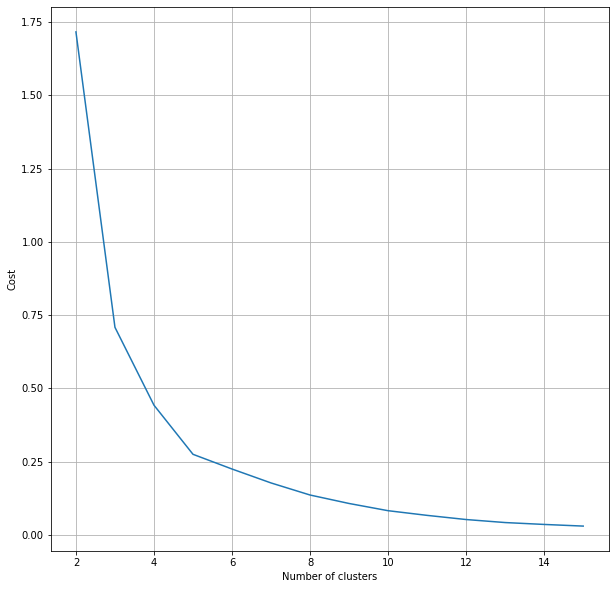

In [17]:
## Determine the number of clusters
plt.rcParams['figure.figsize'] = [10, 10]
plot_cost_vs_clusters(X_daily_mean_workingdays_norm,KMeans, max_clusters=15)

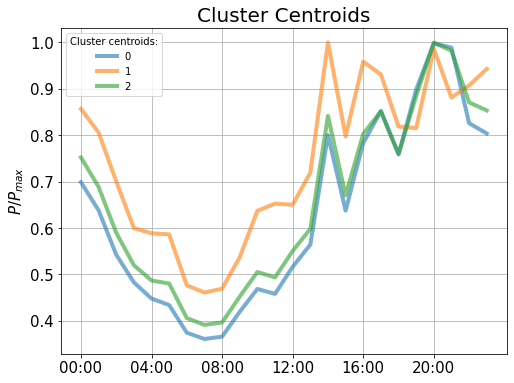

In [20]:
n_clusters = 2

algorithm = KMeans
model = algorithm(n_clusters).fit(X_daily_mean_workingdays_norm)
clust = pd.Series(model.labels_, index=X_daily_mean_workingdays_norm.index)
plot_cluster_centroids(X_daily_mean_workingdays_norm, clust)

C:\Users\54651\Anaconda3\envs\random_env\lib\site-packages\ipykernel_launcher.py:174: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
C:\Users\54651\Anaconda3\envs\random_env\lib\site-packages\ipykernel_launcher.py:174: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


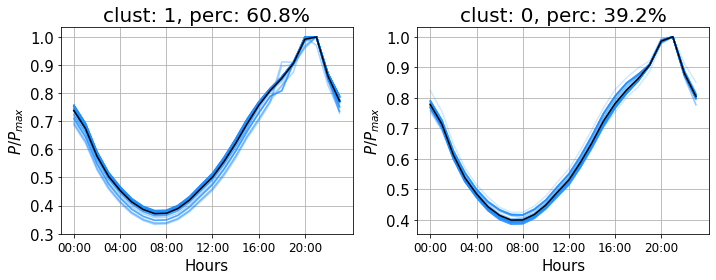

In [36]:
plot_clustered_profiles(X_daily_mean_workingdays_norm, clust)

## Clustering on Average Weekly data

In [37]:
clust

pnode_id
34885183      1
34885185      1
34885193      1
34885195      1
34885197      1
             ..
1552832815    0
2156109345    0
2156111266    0
2156111756    0
2156111774    0
Length: 189, dtype: int32